# Estimating Firebrand Properties from Multiple Video Cameras

This notebook contains Classification of shape of Firebrands, The other notebook contains Prediction of size of Firebrands

## [DATASET](https://drive.google.com/drive/folders/1V8AK0ClZLJiMhDs-p4smjvVLR4GdIC2e?usp=share_link)

In [ ]:
#RUN THIS CELL
!pip install tf_keras_vis
!pip install tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 52 kB 770 kB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 4.7 MB/s 


In [ ]:
#Importing basic libraries

import numpy as np
import os
import shutil
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.ticker import MaxNLocator
from matplotlib import cm
import seaborn as sns
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
#Importing deeplearning libraries

import tensorflow as tf
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Input,Dropout
from tensorflow.keras import regularizers
from tensorflow.keras import optimizers
from matplotlib import pyplot as plt
from tensorflow.keras.utils import img_to_array
from tensorflow.keras.utils import load_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
from numpy import asarray
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from tf_keras_vis.saliency import Saliency
from tf_keras_vis.utils import normalize
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.utils.scores import CategoricalScore
from tensorflow.keras import backend as K
from tf_keras_vis.saliency import Saliency

### Loading and arranging the data for classification problem

First we link the google drive where we have already uploaded the Firebrand data provided by univ ai.

In [ ]:
#Mounting GoogleDrive to fetch dataset easily

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Next we want to create a dataframe which will contain the file path of images and all the required labels such as shape, length, width, height, orientation that is a,b and c.

In [ ]:
!ls drive/MyDrive

In [ ]:
# path where firebrand dataset is located
path = 'drive/MyDrive/synthetic_shape_data_all'
# from the path directory make a list of all the file paths that end in .png or .PNG
all_png_files_path = [str(i) for i in  list(Path(path).rglob('*.[pP][nN][gG]'))]
print(len(all_png_files_path))

6455


In [ ]:
def get_labels_from_file_path(fp):
  """
  input : name of the png file in firebrand dataset
  process: extracts the different labels from the file name
  output: returns a list containing the labels [shape,l,w,h,x,y,z,a,b,c,d1,d2,d3,d4]
  """
  fp = fp.replace('.png','')
  fp = fp.replace('.PNG','')
  fp_split = fp.split('_')
  shape = fp_split[1]
  l = int(fp_split[2][1:])
  w = int(fp_split[3][1:])
  h = int(fp_split[4][1:])
  x = int(fp_split[5][2:])
  y = int(fp_split[6][2:])
  z = int(fp_split[7][2:])
  a = int(fp_split[8][1:])
  b = int(fp_split[9][1:])
  c = int(fp_split[10][1:])
  d1 = int(fp_split[12])
  d2 = int(fp_split[14])
  d3 = int(fp_split[16])
  d4 = int(fp_split[18])
  return [shape,l,w,h,x,y,z,a,b,c,d1,d2,d3,d4]

# iterate over all image paths to get the labels and make a dataframe
df_rows = []
for p in all_png_files_path:
  fp = p.split('/')[-1]
  row = [p]
  row = row + get_labels_from_file_path(fp)
  df_rows.append(row)

df = pd.DataFrame(df_rows, columns = ['img_path','shape','L','W','H','x','y','z','a','b','c','d1','d2','d3','d4'])
print(df.shape)
df.head()

(6455, 15)


,img_path,shape,L,W,H,x,y,z,a,b,c,d1,d2,d3,d4
0,drive/MyDrive/synthetic_shape_data_all/sph_D05...,sph,50,50,50,7,727,559,294,136,104,1479,1496,1222,1234
1,drive/MyDrive/synthetic_shape_data_all/sph_D05...,sph,50,50,50,263,1272,563,147,45,309,989,1388,1353,1677
2,drive/MyDrive/synthetic_shape_data_all/sph_D05...,sph,50,50,50,177,1246,529,115,222,318,1076,1344,1397,1617
3,drive/MyDrive/synthetic_shape_data_all/sph_D05...,sph,50,50,50,307,958,458,57,176,358,1896,2174,1918,2201
4,drive/MyDrive/synthetic_shape_data_all/sph_D05...,sph,50,50,50,258,1266,302,27,299,73,1171,1519,1498,1792


### Split the data as train, val and test

We will keep 80% data in train set, 10% in validation set and 10% in test set

In [ ]:
df_train, df_test = train_test_split(df,test_size = 0.2, stratify = df['shape'])
df_val, df_test = train_test_split(df_test, test_size=0.5, stratify = df_test['shape'])
print('Train df shape:', df_train.shape)
print('Validation df shape:', df_val.shape)
print('Test df shape:', df_test.shape)

Train df shape: (5164, 15)
Validation df shape: (645, 15)
Test df shape: (646, 15)


### Creating the data generators - for shape classification task


In [ ]:
datagen = ImageDataGenerator(
    rescale=1./255)

In [ ]:
train_set = datagen.flow_from_dataframe(
        df_train,
        x_col='img_path',
        y_col='shape',
        target_size=(224, 224),
        batch_size=64)

Found 5164 validated image filenames belonging to 3 classes.


In [ ]:
val_set = datagen.flow_from_dataframe(
        df_val,
        x_col='img_path',
        y_col='shape',
        target_size=(224, 224),
        batch_size=64)

Found 645 validated image filenames belonging to 3 classes.


In [ ]:
test_set = datagen.flow_from_dataframe(
        df_test,
        x_col='img_path',
        y_col='shape',
        target_size=(224, 224),
        batch_size=64,
        shuffle = False)

Found 646 validated image filenames belonging to 3 classes.


### Plotting some of the images from the train set

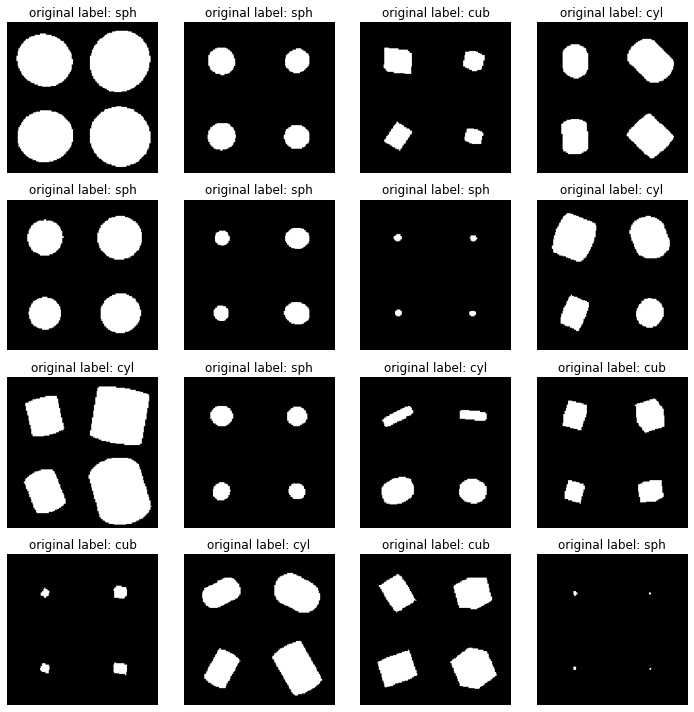

In [ ]:
fig,ax = plt.subplots(4,4,figsize = (10,10))
axis = ax.ravel()

# this are the first batch of data in train set
x_batch, y_batch = next(train_set)
# of that we will only plot first 16
x_batch = x_batch[:16]
y_batch = y_batch[:16]

prediction_to_label = train_set.class_indices 
label_to_prediction = {v:k for k,v in prediction_to_label.items()}

# 
for i in range(16):
  axis[i].imshow(x_batch[i])
  axis[i].set_title('original label: '+label_to_prediction[y_batch[i].argmax()])
  axis[i].axis('off')
plt.tight_layout()
plt.show()

In [ ]:
x_batch[0].shape

(224, 224, 3)

### Training a CNN model

1. First we train a baseline model

In [ ]:
#Baseline model for classification

# Initialize a sequential model
bmodel = Sequential(name="Classification")

# First convolution layer
bmodel.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(224, 224, 3)))

# First max-pooling layer
bmodel.add(MaxPool2D(pool_size=(3,3)))

# Second convolution layer
bmodel.add(Conv2D(64, (3, 3), activation='relu'))

# Second max-pooling layer
bmodel.add(MaxPool2D(pool_size=(3,3)))

# Flatten layer
bmodel.add(Flatten())

# Fully connected dense layer
bmodel.add(Dense(256,activation='relu'))

# Output layer
bmodel.add(Dense(3,activation='softmax'))

# Compiling the model
bmodel.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

bmodel.summary()

Model: "Classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 24, 24, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 36864)             0         
                                                                 
 dense (Dense)               (None, 256)            

In [ ]:
#Fitting baseline model and storing history
bmodel_history=bmodel.fit(train_set, validation_data = val_set, epochs=5, verbose=1)

Epoch 1/5
81/81 [==============================] - 1355s 17s/step - loss: 0.9937 - accuracy: 0.5465 - val_loss: 0.6135 - val_accuracy: 0.7364
Epoch 2/5
81/81 [==============================] - 9s 114ms/step - loss: 0.4594 - accuracy: 0.7895 - val_loss: 0.4564 - val_accuracy: 0.7721
Epoch 3/5
81/81 [==============================] - 9s 116ms/step - loss: 0.2675 - accuracy: 0.8881 - val_loss: 0.3618 - val_accuracy: 0.8620
Epoch 4/5
81/81 [==============================] - 9s 115ms/step - loss: 0.1665 - accuracy: 0.9324 - val_loss: 0.3146 - val_accuracy: 0.8527
Epoch 5/5
81/81 [==============================] - 9s 114ms/step - loss: 0.1155 - accuracy: 0.9541 - val_loss: 0.3736 - val_accuracy: 0.8605


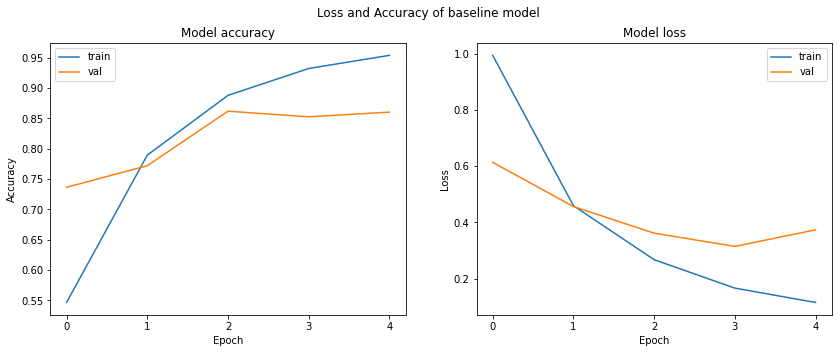

In [ ]:
# now we plot the accuracy and loss
fig, ax = plt.subplots(1,2,figsize=(14,5))
ax[0].plot(bmodel_history.history['accuracy'])
ax[0].plot(bmodel_history.history['val_accuracy'])
ax[0].set_title('Model accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].xaxis.set_major_locator(MaxNLocator(integer=True)) #https://www.scivision.dev/matplotlib-force-integer-labeling-of-axis/
ax[0].legend(['train', 'val'], loc='best')

ax[1].plot(bmodel_history.history['loss'])
ax[1].plot(bmodel_history.history['val_loss'])
ax[1].set_title('Model loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].xaxis.set_major_locator(MaxNLocator(integer=True))
ax[1].legend(['train', 'val'], loc='best')
fig.suptitle('Loss and Accuracy of baseline model')
plt.show()

In [ ]:
bloss, bacc = bmodel.evaluate(test_set)
print(f'Loss on test set for baseline model is: {bloss:0.2f}')
print(f'Accuracy on test set for baseline model is: {bacc:0.2f}')

11/11 [==============================] - 129s 13s/step - loss: 0.3716 - accuracy: 0.8607
Loss on test set for baseline model is: 0.37
Accuracy on test set for baseline model is: 0.86


2. We try to improve the baseline model by adding more layers and regularization

In [ ]:
#Improved model for classification

# Initialize a sequential model
cmodel = Sequential(name="Classification")

# First convolution layer
cmodel.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(224, 224, 3)))

# Second convolution layer
cmodel.add(Conv2D(32, (3, 3), activation='relu', padding='same'))

# First max-pooling layer
cmodel.add(MaxPool2D(pool_size=(2,2)))
cmodel.add(Dropout(rate=0.1))

# Third convolution layer
cmodel.add(Conv2D(64, (3, 3), activation='relu', padding='same'))

# Fourth convolution layer
cmodel.add(Conv2D(64, (3, 3), activation='relu', padding='same'))

# Second max-pooling layer
cmodel.add(MaxPool2D(pool_size=(2,2)))
cmodel.add(Dropout(rate=0.1))

# Fifth convolution layer
cmodel.add(Conv2D(128, (3, 3), activation='relu', padding='same'))

# # Sixth convolution layer
cmodel.add(Conv2D(128, (3, 3), activation='relu', padding='same'))

# Third max-pooling layer
cmodel.add(MaxPool2D(pool_size=(2,2)))
cmodel.add(Dropout(rate=0.1))

# Flatten layer
cmodel.add(Flatten())

# Fully connected dense layer
cmodel.add(Dense(192,activation='relu'))

# Output layer
cmodel.add(Dense(3,activation='softmax'))

# Compiling the model
cmodel.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

cmodel.summary()

Model: "Classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 224, 224, 32)      896       
                                                                 
 conv2d_3 (Conv2D)           (None, 224, 224, 32)      9248      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 112, 112, 32)     0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 112, 112, 32)      0         
                                                                 
 conv2d_4 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 conv2d_5 (Conv2D)           (None, 112, 112, 64)      36928     
                                                    

In [ ]:
#Defining early stopping for regularisation
es=EarlyStopping(restore_best_weights=True, monitor='val_loss', patience=5, verbose=1, mode='min')
#Fitting the improved version of classification model and storing history
cmodel_history=cmodel.fit(train_set, validation_data = val_set, epochs=20, verbose=1, callbacks=[es])

Epoch 1/20
81/81 [==============================] - 12s 128ms/step - loss: 0.9719 - accuracy: 0.5229 - val_loss: 0.6224 - val_accuracy: 0.7008
Epoch 2/20
81/81 [==============================] - 9s 117ms/step - loss: 0.4170 - accuracy: 0.8044 - val_loss: 0.2857 - val_accuracy: 0.8822
Epoch 3/20
81/81 [==============================] - 9s 115ms/step - loss: 0.1947 - accuracy: 0.9218 - val_loss: 0.2672 - val_accuracy: 0.8946
Epoch 4/20
81/81 [==============================] - 9s 114ms/step - loss: 0.1530 - accuracy: 0.9371 - val_loss: 0.2451 - val_accuracy: 0.9132
Epoch 5/20
81/81 [==============================] - 9s 116ms/step - loss: 0.0970 - accuracy: 0.9609 - val_loss: 0.1802 - val_accuracy: 0.9240
Epoch 6/20
81/81 [==============================] - 9s 114ms/step - loss: 0.0723 - accuracy: 0.9702 - val_loss: 0.1973 - val_accuracy: 0.9287
Epoch 7/20
81/81 [==============================] - 9s 113ms/step - loss: 0.0739 - accuracy: 0.9690 - val_loss: 0.2110 - val_accuracy: 0.9209
Epoch

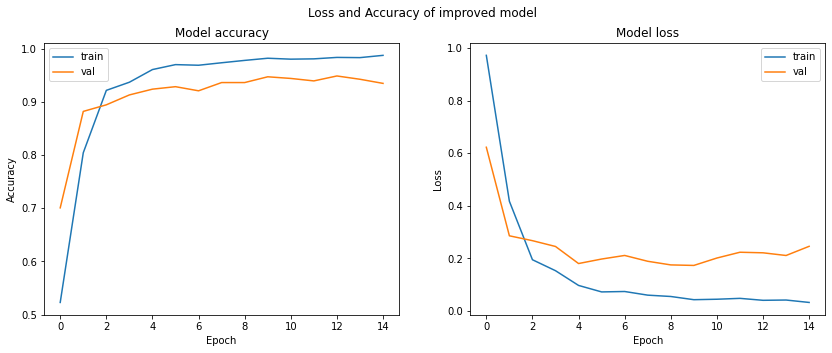

In [ ]:
# now we plot the accuracy and loss
fig, ax = plt.subplots(1,2,figsize=(14,5))
ax[0].plot(cmodel_history.history['accuracy'])
ax[0].plot(cmodel_history.history['val_accuracy'])
ax[0].set_title('Model accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['train', 'val'], loc='best')

ax[1].plot(cmodel_history.history['loss'])
ax[1].plot(cmodel_history.history['val_loss'])
ax[1].set_title('Model loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['train', 'val'], loc='best')
fig.suptitle('Loss and Accuracy of improved model')
plt.show()

In [ ]:
closs, cacc = cmodel.evaluate(test_set)
print(f'Loss on test set for improved model is: {closs:0.2f}')
print(f'Accuracy on test set for improved model is: {cacc:0.2f}')

11/11 [==============================] - 1s 99ms/step - loss: 0.1570 - accuracy: 0.9412
Loss on test set for improved model is: 0.16
Accuracy on test set for improved model is: 0.94


#### Fine-tuning SOTA models

1. We fine-tune the VGG-16 model below

In [ ]:
# import VGG16 and pass the necessary arguments
from keras.applications import VGG16
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [ ]:
# we freeze all the layers except the last block
for layer in vgg_model.layers[:15]:
    layer.trainable = False
# let's check if we freezed correctly
for i, layer in enumerate(vgg_model.layers):
    print(i, layer.name, layer.trainable)

0 input_6 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 False
12 block4_conv2 False
13 block4_conv3 False
14 block4_pool False
15 block5_conv1 True
16 block5_conv2 True
17 block5_conv3 True
18 block5_pool True


In [ ]:
# training dataset on last four layers of model
op = vgg_model.output
op = Flatten()(op) 
op = Dense(512, activation='relu')(op)
op = Dropout(0.3)(op) 
op = Dense(256, activation='relu')(op)
op = Dense(3, activation='softmax')(op) 
transfer_model = Model(inputs=vgg_model.input, outputs=op)

In [ ]:
transfer_model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [ ]:
transfer_model.compile(loss='categorical_crossentropy', metrics = ['accuracy'], optimizer = optimizers.Adam(learning_rate = 1e-4))

In [ ]:
es = EarlyStopping(monitor="val_loss", patience=5)
t_history = transfer_model.fit(train_set, validation_data = val_set, epochs=20, verbose=1,callbacks=[es])

Epoch 1/20
81/81 [==============================] - 11s 121ms/step - loss: 0.2121 - accuracy: 0.9065 - val_loss: 0.1337 - val_accuracy: 0.9302
Epoch 2/20
81/81 [==============================] - 10s 121ms/step - loss: 0.0897 - accuracy: 0.9607 - val_loss: 0.1192 - val_accuracy: 0.9519
Epoch 3/20
81/81 [==============================] - 10s 120ms/step - loss: 0.1087 - accuracy: 0.9553 - val_loss: 0.0892 - val_accuracy: 0.9597
Epoch 4/20
81/81 [==============================] - 10s 120ms/step - loss: 0.0930 - accuracy: 0.9622 - val_loss: 0.0990 - val_accuracy: 0.9597
Epoch 5/20
81/81 [==============================] - 10s 121ms/step - loss: 0.0758 - accuracy: 0.9680 - val_loss: 0.1493 - val_accuracy: 0.9504
Epoch 6/20
81/81 [==============================] - 10s 121ms/step - loss: 0.0681 - accuracy: 0.9723 - val_loss: 0.1121 - val_accuracy: 0.9504
Epoch 7/20
81/81 [==============================] - 10s 121ms/step - loss: 0.0601 - accuracy: 0.9727 - val_loss: 0.0781 - val_accuracy: 0.9705

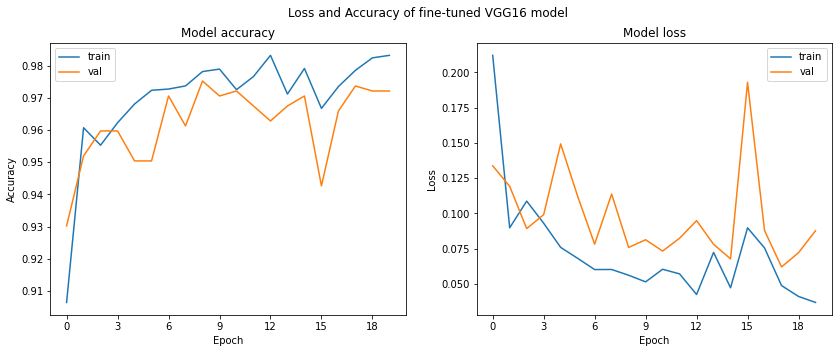

In [ ]:
# now we plot the accuracy and loss
fig, ax = plt.subplots(1,2,figsize=(14,5))
ax[0].plot(t_history.history['accuracy'])
ax[0].plot(t_history.history['val_accuracy'])
ax[0].set_title('Model accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].xaxis.set_major_locator(MaxNLocator(integer=True))
ax[0].legend(['train', 'val'], loc='best')

ax[1].plot(t_history.history['loss'])
ax[1].plot(t_history.history['val_loss'])
ax[1].set_title('Model loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].xaxis.set_major_locator(MaxNLocator(integer=True))
ax[1].legend(['train', 'val'], loc='best')
fig.suptitle('Loss and Accuracy of fine-tuned VGG16 model')
plt.show()

In [ ]:
tloss, tacc = transfer_model.evaluate(test_set)
print(f'Loss on test set for fine-tuned VGG-16 model is: {tloss:0.2f}')
print(f'Accuracy on test set for fine-tuned VGG-16 model is: {tacc:0.2f}')

11/11 [==============================] - 1s 97ms/step - loss: 0.0910 - accuracy: 0.9628
Loss on test set for fine-tuned VGG-16 model is: 0.09
Accuracy on test set for fine-tuned VGG-16 model is: 0.96


2. We fine-tune the resnet model below

In [ ]:
# import VGG16 and pass the necessary arguments
from keras.applications import ResNet50
resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

94765736/94765736 [==============================] - 1s 0us/step


In [ ]:
# we freeze all the layers except the last block
for layer in resnet_model.layers[:-10]:
    layer.trainable = False
# let's check if we freezed correctly
for i, layer in enumerate(resnet_model.layers):
    print(i, layer.name, layer.trainable)

0 input_2 False
1 conv1_pad False
2 conv1_conv False
3 conv1_bn False
4 conv1_relu False
5 pool1_pad False
6 pool1_pool False
7 conv2_block1_1_conv False
8 conv2_block1_1_bn False
9 conv2_block1_1_relu False
10 conv2_block1_2_conv False
11 conv2_block1_2_bn False
12 conv2_block1_2_relu False
13 conv2_block1_0_conv False
14 conv2_block1_3_conv False
15 conv2_block1_0_bn False
16 conv2_block1_3_bn False
17 conv2_block1_add False
18 conv2_block1_out False
19 conv2_block2_1_conv False
20 conv2_block2_1_bn False
21 conv2_block2_1_relu False
22 conv2_block2_2_conv False
23 conv2_block2_2_bn False
24 conv2_block2_2_relu False
25 conv2_block2_3_conv False
26 conv2_block2_3_bn False
27 conv2_block2_add False
28 conv2_block2_out False
29 conv2_block3_1_conv False
30 conv2_block3_1_bn False
31 conv2_block3_1_relu False
32 conv2_block3_2_conv False
33 conv2_block3_2_bn False
34 conv2_block3_2_relu False
35 conv2_block3_3_conv False
36 conv2_block3_3_bn False
37 conv2_block3_add False
38 conv2_bloc

In [ ]:
# training dataset on last four layers of model
op = resnet_model.output
op = Flatten()(op) 
op = Dense(512, activation='relu')(op)
op = Dropout(0.3)(op) 
op = Dense(256, activation='relu')(op)
op = Dense(3, activation='softmax')(op) 
transfer_model2 = Model(inputs=resnet_model.input, outputs=op)

transfer_model2.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [ ]:
transfer_model2.compile(loss='categorical_crossentropy', metrics = ['accuracy'], optimizer = optimizers.Adam(learning_rate = 1e-4))

In [ ]:
es = EarlyStopping(monitor="val_loss", patience=5)
t_history2 = transfer_model2.fit(train_set, validation_data = val_set, epochs=20, verbose=1,callbacks=[es])

Epoch 1/20
81/81 [==============================] - 14s 133ms/step - loss: 0.7477 - accuracy: 0.7277 - val_loss: 1.0970 - val_accuracy: 0.5209
Epoch 2/20
81/81 [==============================] - 10s 117ms/step - loss: 0.3370 - accuracy: 0.8491 - val_loss: 1.4628 - val_accuracy: 0.5240
Epoch 3/20
81/81 [==============================] - 9s 116ms/step - loss: 0.2534 - accuracy: 0.8871 - val_loss: 1.8184 - val_accuracy: 0.5318
Epoch 4/20
81/81 [==============================] - 9s 116ms/step - loss: 0.2361 - accuracy: 0.8968 - val_loss: 0.3989 - val_accuracy: 0.8217
Epoch 5/20
81/81 [==============================] - 9s 115ms/step - loss: 0.1920 - accuracy: 0.9127 - val_loss: 0.4707 - val_accuracy: 0.7767
Epoch 6/20
81/81 [==============================] - 9s 116ms/step - loss: 0.1715 - accuracy: 0.9187 - val_loss: 0.3230 - val_accuracy: 0.8853
Epoch 7/20
81/81 [==============================] - 9s 116ms/step - loss: 0.1709 - accuracy: 0.9183 - val_loss: 0.2884 - val_accuracy: 0.8961
Epoc

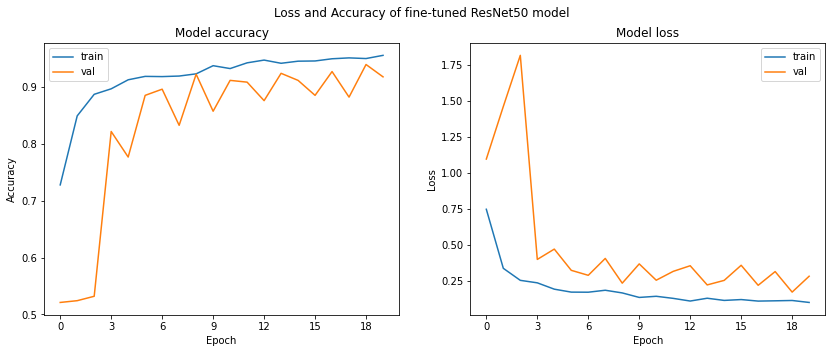

In [ ]:
# now we plot the accuracy and loss
fig, ax = plt.subplots(1,2,figsize=(14,5))
ax[0].plot(t_history2.history['accuracy'])
ax[0].plot(t_history2.history['val_accuracy'])
ax[0].set_title('Model accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].xaxis.set_major_locator(MaxNLocator(integer=True))
ax[0].legend(['train', 'val'], loc='best')

ax[1].plot(t_history2.history['loss'])
ax[1].plot(t_history2.history['val_loss'])
ax[1].set_title('Model loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].xaxis.set_major_locator(MaxNLocator(integer=True))
ax[1].legend(['train', 'val'], loc='best')
fig.suptitle('Loss and Accuracy of fine-tuned ResNet50 model')
plt.show()

In [ ]:
tloss2, tacc2 = transfer_model2.evaluate(test_set)
print(f'Loss on test set for fine-tuned ResNet50 is: {tloss2:0.2f}')
print(f'Accuracy on test set for fine-tuned ResNet50 is: {tacc2:0.2f}')

11/11 [==============================] - 1s 109ms/step - loss: 0.2897 - accuracy: 0.9149
Loss on test set for fine-tuned ResNet50 is: 0.29
Accuracy on test set for fine-tuned ResNet50 is: 0.91


3. We will fine-tune MobileNet

In [ ]:
# import MobileNet and pass the necessary arguments
from keras.applications import MobileNet
mobilenet_model = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

17225924/17225924 [==============================] - 0s 0us/step


In [ ]:
# we freeze all the layers except the last block
for layer in mobilenet_model.layers[:-6]:
    layer.trainable = False
# let's check if we freezed correctly
for i, layer in enumerate(mobilenet_model.layers):
    print(i, layer.name, layer.trainable)

0 input_3 False
1 conv1 False
2 conv1_bn False
3 conv1_relu False
4 conv_dw_1 False
5 conv_dw_1_bn False
6 conv_dw_1_relu False
7 conv_pw_1 False
8 conv_pw_1_bn False
9 conv_pw_1_relu False
10 conv_pad_2 False
11 conv_dw_2 False
12 conv_dw_2_bn False
13 conv_dw_2_relu False
14 conv_pw_2 False
15 conv_pw_2_bn False
16 conv_pw_2_relu False
17 conv_dw_3 False
18 conv_dw_3_bn False
19 conv_dw_3_relu False
20 conv_pw_3 False
21 conv_pw_3_bn False
22 conv_pw_3_relu False
23 conv_pad_4 False
24 conv_dw_4 False
25 conv_dw_4_bn False
26 conv_dw_4_relu False
27 conv_pw_4 False
28 conv_pw_4_bn False
29 conv_pw_4_relu False
30 conv_dw_5 False
31 conv_dw_5_bn False
32 conv_dw_5_relu False
33 conv_pw_5 False
34 conv_pw_5_bn False
35 conv_pw_5_relu False
36 conv_pad_6 False
37 conv_dw_6 False
38 conv_dw_6_bn False
39 conv_dw_6_relu False
40 conv_pw_6 False
41 conv_pw_6_bn False
42 conv_pw_6_relu False
43 conv_dw_7 False
44 conv_dw_7_bn False
45 conv_dw_7_relu False
46 conv_pw_7 False
47 conv_pw_7_bn 

In [ ]:
# training dataset on last four layers of model
op = mobilenet_model.output
op = Flatten()(op) 
op = Dense(512, activation='relu')(op)
op = Dropout(0.3)(op) 
op = Dense(256, activation='relu')(op)
op = Dense(3, activation='softmax')(op) 
transfer_model3 = Model(inputs=mobilenet_model.input, outputs=op)

transfer_model3.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                                    

In [ ]:
transfer_model3.compile(loss='categorical_crossentropy', metrics = ['accuracy'], optimizer = optimizers.Adam(learning_rate = 1e-4))

In [ ]:
es = EarlyStopping(monitor="val_loss", patience=5)
t_history3 = transfer_model3.fit(train_set, validation_data = val_set, epochs=20, verbose=1,callbacks=[es])

Epoch 1/20
81/81 [==============================] - 12s 123ms/step - loss: 0.3606 - accuracy: 0.9109 - val_loss: 0.1840 - val_accuracy: 0.9116
Epoch 2/20
81/81 [==============================] - 9s 115ms/step - loss: 0.1650 - accuracy: 0.9487 - val_loss: 0.2154 - val_accuracy: 0.8992
Epoch 3/20
81/81 [==============================] - 10s 117ms/step - loss: 0.1138 - accuracy: 0.9584 - val_loss: 0.1305 - val_accuracy: 0.9473
Epoch 4/20
81/81 [==============================] - 9s 116ms/step - loss: 0.0907 - accuracy: 0.9667 - val_loss: 0.1449 - val_accuracy: 0.9411
Epoch 5/20
81/81 [==============================] - 10s 124ms/step - loss: 0.0749 - accuracy: 0.9684 - val_loss: 0.1728 - val_accuracy: 0.9333
Epoch 6/20
81/81 [==============================] - 10s 119ms/step - loss: 0.0842 - accuracy: 0.9669 - val_loss: 0.2736 - val_accuracy: 0.9380
Epoch 7/20
81/81 [==============================] - 10s 124ms/step - loss: 0.0662 - accuracy: 0.9752 - val_loss: 0.1574 - val_accuracy: 0.9674
E

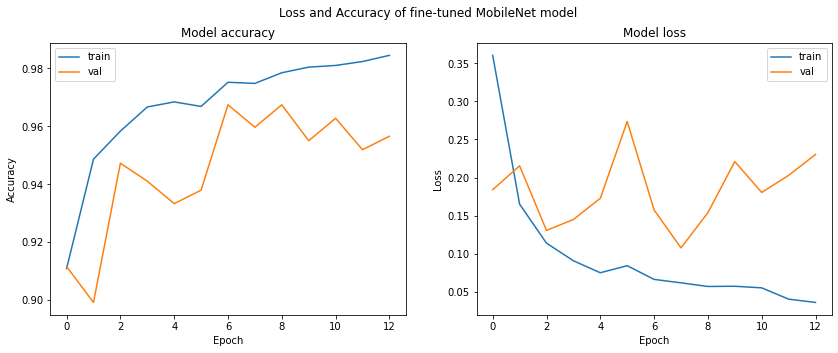

In [ ]:
# now we plot the accuracy and loss
fig, ax = plt.subplots(1,2,figsize=(14,5))
ax[0].plot(t_history3.history['accuracy'])
ax[0].plot(t_history3.history['val_accuracy'])
ax[0].set_title('Model accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['train', 'val'], loc='best')

ax[1].plot(t_history3.history['loss'])
ax[1].plot(t_history3.history['val_loss'])
ax[1].set_title('Model loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['train', 'val'], loc='best')
fig.suptitle('Loss and Accuracy of fine-tuned MobileNet model')
plt.show()

In [ ]:
tloss3, tacc3 = transfer_model3.evaluate(test_set)
print(f'Loss on test set for fine-tuned Mobilenet model is: {tloss3:0.2f}')
print(f'Accuracy on test set for fine-tuned Mobilenet model is: {tacc3:0.2f}')

11/11 [==============================] - 1s 102ms/step - loss: 0.2103 - accuracy: 0.9613
Loss on test set for fine-tuned Mobilenet model is: 0.21
Accuracy on test set for fine-tuned Mobilenet model is: 0.96


In [ ]:
# import DenseNet and pass the necessary arguments
from keras.applications import DenseNet201
densenet_model = DenseNet201(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

74836368/74836368 [==============================] - 0s 0us/step


In [ ]:
# we freeze all the layers except the last block
for layer in densenet_model.layers[:-7]:
    layer.trainable = False
# let's check if we freezed correctly
for i, layer in enumerate(densenet_model.layers):
    print(i, layer.name, layer.trainable)

0 input_4 False
1 zero_padding2d False
2 conv1/conv False
3 conv1/bn False
4 conv1/relu False
5 zero_padding2d_1 False
6 pool1 False
7 conv2_block1_0_bn False
8 conv2_block1_0_relu False
9 conv2_block1_1_conv False
10 conv2_block1_1_bn False
11 conv2_block1_1_relu False
12 conv2_block1_2_conv False
13 conv2_block1_concat False
14 conv2_block2_0_bn False
15 conv2_block2_0_relu False
16 conv2_block2_1_conv False
17 conv2_block2_1_bn False
18 conv2_block2_1_relu False
19 conv2_block2_2_conv False
20 conv2_block2_concat False
21 conv2_block3_0_bn False
22 conv2_block3_0_relu False
23 conv2_block3_1_conv False
24 conv2_block3_1_bn False
25 conv2_block3_1_relu False
26 conv2_block3_2_conv False
27 conv2_block3_concat False
28 conv2_block4_0_bn False
29 conv2_block4_0_relu False
30 conv2_block4_1_conv False
31 conv2_block4_1_bn False
32 conv2_block4_1_relu False
33 conv2_block4_2_conv False
34 conv2_block4_concat False
35 conv2_block5_0_bn False
36 conv2_block5_0_relu False
37 conv2_block5_1_

In [ ]:
# training dataset on last four layers of model
op = densenet_model.output
op = Flatten()(op) 
op = Dense(512, activation='relu')(op)
op = Dropout(0.3)(op) 
op = Dense(256, activation='relu')(op)
op = Dense(3, activation='softmax')(op) 
transfer_model4 = Model(inputs=densenet_model.input, outputs=op)

transfer_model4.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_4[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                            

In [ ]:
transfer_model4.compile(loss='categorical_crossentropy', metrics = ['accuracy'], optimizer = optimizers.Adam(learning_rate = 1e-4))

In [ ]:
es = EarlyStopping(monitor="val_loss", patience=5)
t_history4 = transfer_model4.fit(train_set, validation_data = val_set, epochs=20, verbose=1,callbacks=[es])

Epoch 1/20
81/81 [==============================] - 25s 183ms/step - loss: 0.3880 - accuracy: 0.8877 - val_loss: 0.1073 - val_accuracy: 0.9581
Epoch 2/20
81/81 [==============================] - 10s 124ms/step - loss: 0.1557 - accuracy: 0.9413 - val_loss: 0.1559 - val_accuracy: 0.9442
Epoch 3/20
81/81 [==============================] - 10s 124ms/step - loss: 0.1371 - accuracy: 0.9491 - val_loss: 0.1362 - val_accuracy: 0.9457
Epoch 4/20
81/81 [==============================] - 10s 124ms/step - loss: 0.1230 - accuracy: 0.9493 - val_loss: 0.0887 - val_accuracy: 0.9643
Epoch 5/20
81/81 [==============================] - 10s 124ms/step - loss: 0.1128 - accuracy: 0.9524 - val_loss: 0.1191 - val_accuracy: 0.9488
Epoch 6/20
81/81 [==============================] - 10s 123ms/step - loss: 0.0961 - accuracy: 0.9611 - val_loss: 0.1264 - val_accuracy: 0.9550
Epoch 7/20
81/81 [==============================] - 10s 124ms/step - loss: 0.0913 - accuracy: 0.9619 - val_loss: 0.1387 - val_accuracy: 0.9473

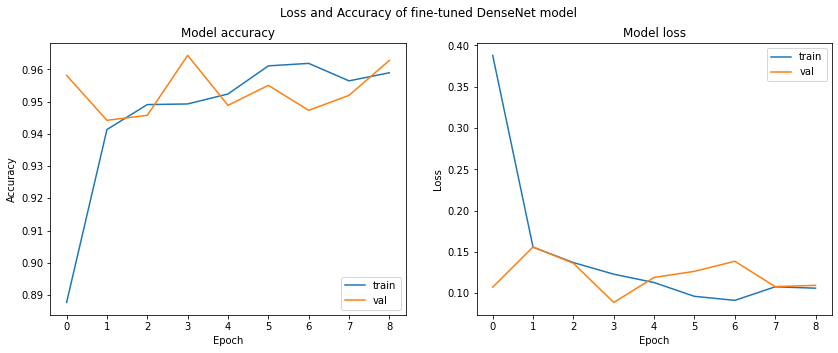

In [ ]:
# now we plot the accuracy and loss
fig, ax = plt.subplots(1,2,figsize=(14,5))
ax[0].plot(t_history4.history['accuracy'])
ax[0].plot(t_history4.history['val_accuracy'])
ax[0].set_title('Model accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['train', 'val'], loc='best')

ax[1].plot(t_history4.history['loss'])
ax[1].plot(t_history4.history['val_loss'])
ax[1].set_title('Model loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['train', 'val'], loc='best')
fig.suptitle('Loss and Accuracy of fine-tuned DenseNet model')
plt.show()

In [ ]:
tloss4, tacc4 = transfer_model4.evaluate(test_set)
print(f'Loss on test set for fine-tuned DenseNet model is: {tloss4:0.2f}')
print(f'Accuracy on test set for fine-tuned DenseNet model is: {tacc4:0.2f}')

11/11 [==============================] - 2s 166ms/step - loss: 0.1235 - accuracy: 0.9582
Loss on test set for fine-tuned DenseNet model is: 0.12
Accuracy on test set for fine-tuned DenseNet model is: 0.96


In [ ]:
from prettytable import PrettyTable
  
# Specify the Column Names while initializing the Table
myTable = PrettyTable(["Model name", "Test Loss", "Test Accuracy"])
  
# Add rows
myTable.add_row(["Baseline Model", f"{bloss:0.2f}", f"{bacc:0.2f}"])
myTable.add_row(["Improved Model", f"{closs:0.2f}", f"{cacc:0.2f}"])
myTable.add_row(["Fine-tuned VGG16 Model", f"{tloss:0.2f}", f"{tacc:0.2f}"])
myTable.add_row(["Fine-tuned ResNet50 Model", f"{tloss2:0.2f}", f"{tacc2:0.2f}"])
myTable.add_row(["Fine-tuned MobileNet Model", f"{tloss3:0.2f}", f"{tacc3:0.2f}"])
myTable.add_row(["Fine-tuned DenseNet Model", f"{tloss4:0.2f}", f"{tacc4:0.2f}"])

print(myTable)

+----------------------------+-----------+---------------+
|         Model name         | Test Loss | Test Accuracy |
+----------------------------+-----------+---------------+
|       Baseline Model       |    0.37   |      0.86     |
|       Improved Model       |    0.16   |      0.94     |
|   Fine-tuned VGG16 Model   |    0.09   |      0.96     |
| Fine-tuned ResNet50 Model  |    0.29   |      0.91     |
| Fine-tuned MobileNet Model |    0.21   |      0.96     |
| Fine-tuned DenseNet Model  |    0.12   |      0.96     |
+----------------------------+-----------+---------------+


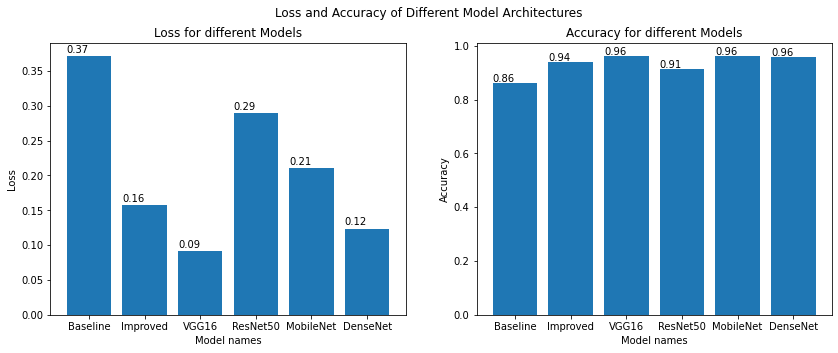

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(14,5))

x = ['Baseline', 'Improved', 'VGG16', 'ResNet50', 'MobileNet', 'DenseNet']
y_val_loss = [bmodel_history.history['val_loss'][-1], cmodel_history.history['val_loss'][-1], t_history.history['val_loss'][-1],
             t_history2.history['val_loss'][-1], t_history3.history['val_loss'][-1], t_history4.history['val_loss'][-1]]

y_val_acc = [bmodel_history.history['val_accuracy'][-1], cmodel_history.history['val_accuracy'][-1], t_history.history['val_accuracy'][-1],
             t_history2.history['val_accuracy'][-1], t_history3.history['val_accuracy'][-1], t_history4.history['val_accuracy'][-1]]

y_loss = [bloss, closs, tloss, tloss2, tloss3, tloss4]
y_acc = [bacc, cacc, tacc, tacc2, tacc3, tacc4]
bars = ax[0].bar(x, y_loss)
ax[0].set_title('Loss for different Models')
ax[0].set_xlabel('Model names')
ax[0].set_ylabel('Loss')


for bar in bars:
    yval = bar.get_height()
    ax[0].text(bar.get_x(), yval + .005, f'{yval:0.2f}')

bars2 = ax[1].bar(x, y_acc)
ax[1].set_title('Accuracy for different Models')
ax[1].set_xlabel('Model names')
ax[1].set_ylabel('Accuracy')
for bar in bars2:
    yval = bar.get_height()
    ax[1].text(bar.get_x(), yval + .005, f'{yval:0.2f}')
fig.suptitle('Loss and Accuracy of Different Model Architectures')
plt.show()

### Plotting the confusion matrix

In [ ]:
prediction_to_label = train_set.class_indices
label_to_prediction = {v:k for k,v in prediction_to_label.items()}  
print(label_to_prediction)

{0: 'cub', 1: 'cyl', 2: 'sph'}


In [ ]:
prediction_to_label = test_set.class_indices
label_to_prediction_test = {v:k for k,v in prediction_to_label.items()}  
print(label_to_prediction_test)

{0: 'cub', 1: 'cyl', 2: 'sph'}


In [ ]:
y_true = test_set.labels

y_pred_base = bmodel.predict(test_set)
cm_base = confusion_matrix(y_true, [i.argmax() for i in y_pred_base])

y_pred_improved = cmodel.predict(test_set)
cm_improved = confusion_matrix(y_true, [i.argmax() for i in y_pred_improved])

y_pred_vgg = transfer_model.predict(test_set)
cm_vgg = confusion_matrix(y_true, [i.argmax() for i in y_pred_vgg])

y_pred_resnet = transfer_model2.predict(test_set)
cm_resnet = confusion_matrix(y_true, [i.argmax() for i in y_pred_resnet])

y_pred_mobilenet = transfer_model3.predict(test_set)
cm_mobilenet = confusion_matrix(y_true, [i.argmax() for i in y_pred_mobilenet])

y_pred_densenet = transfer_model4.predict(test_set)
cm_densenet = confusion_matrix(y_true, [i.argmax() for i in y_pred_densenet])

11/11 [==============================] - 1s 105ms/step


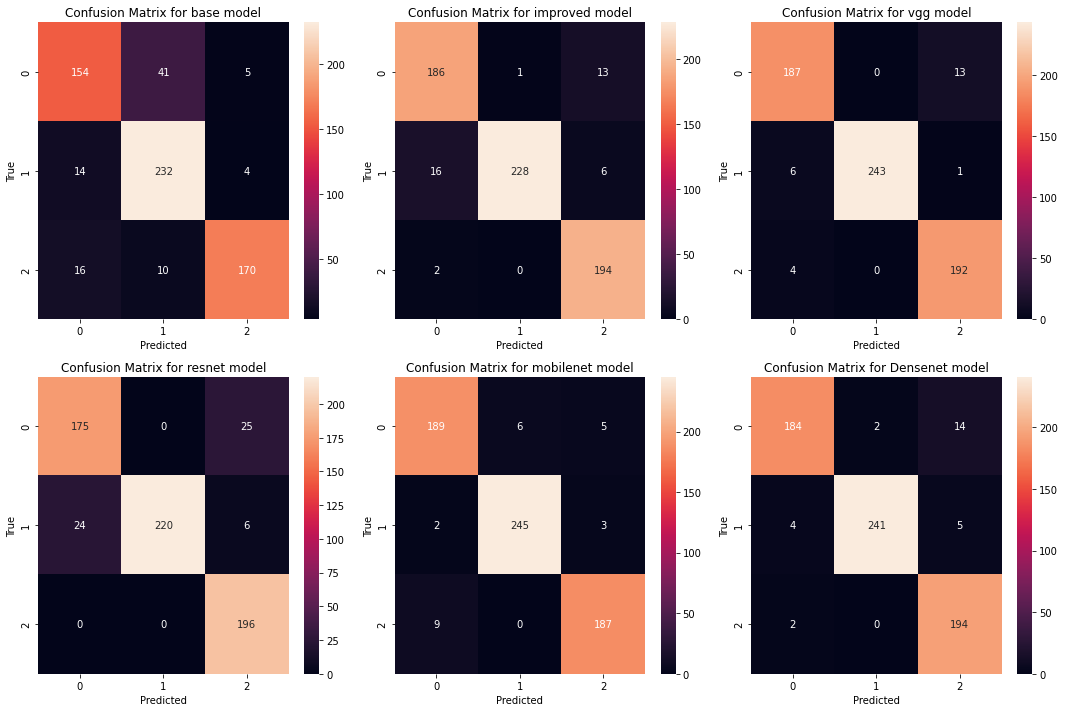

In [ ]:
fig, ax = plt.subplots(2,3,figsize=(15,10))
sns.heatmap(cm_base, annot=True, fmt='d', ax=ax[0][0])
sns.heatmap(cm_improved, annot=True, fmt='d', ax=ax[0][1])
sns.heatmap(cm_vgg, annot=True, fmt='d', ax=ax[0][2])
sns.heatmap(cm_resnet, annot=True, fmt='d', ax=ax[1][0])
sns.heatmap(cm_mobilenet, annot=True, fmt='d', ax=ax[1][1])
sns.heatmap(cm_densenet, annot=True, fmt='d', ax=ax[1][2])

ax[0][0].set_xlabel('Predicted')
ax[0][0].set_ylabel('True')
ax[0][0].set_title('Confusion Matrix for base model')

ax[0][1].set_xlabel('Predicted')
ax[0][1].set_ylabel('True')
ax[0][1].set_title('Confusion Matrix for improved model')

ax[0][2].set_xlabel('Predicted')
ax[0][2].set_ylabel('True')
ax[0][2].set_title('Confusion Matrix for vgg model')

ax[1][0].set_xlabel('Predicted')
ax[1][0].set_ylabel('True')
ax[1][0].set_title('Confusion Matrix for resnet model')

ax[1][1].set_xlabel('Predicted')
ax[1][1].set_ylabel('True')
ax[1][1].set_title('Confusion Matrix for mobilenet model')

ax[1][2].set_xlabel('Predicted')
ax[1][2].set_ylabel('True')
ax[1][2].set_title('Confusion Matrix for Densenet model')

plt.tight_layout()
plt.show()

### Saliency map and GradCam for failed prediction

In [ ]:
x_test = train_set.filepaths

In [ ]:
# First we need to find some instances of mistakes.
y_pred_vgg = transfer_model.predict(test_set)
y_pred_vgg = [i.argmax() for i in y_pred_vgg]
failed_predictions = [i for i in range(len(y_true)) if y_true[i]!=y_pred_vgg[i]]
print(failed_predictions)
print(len(failed_predictions))

11/11 [==============================] - 1s 94ms/step
[8, 10, 25, 31, 99, 122, 149, 175, 192, 208, 261, 342, 348, 375, 422, 427, 439, 516, 528, 564, 594, 616, 631, 642]
24


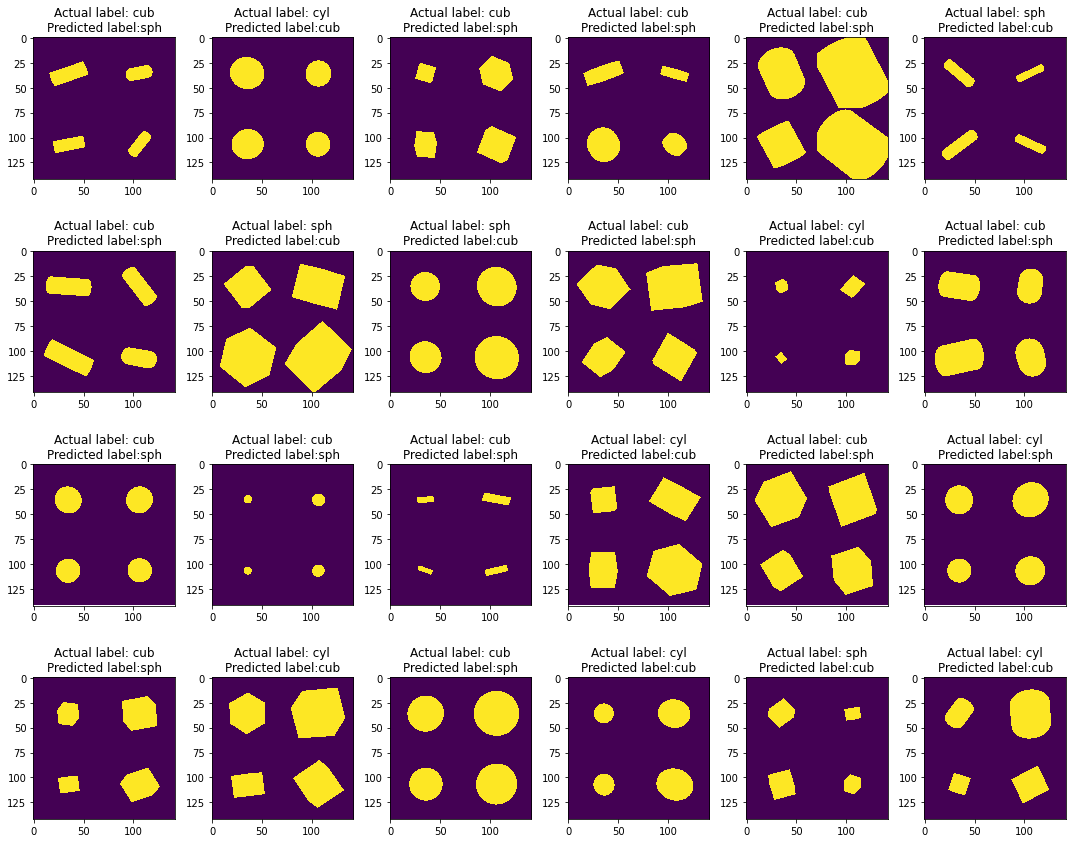

In [ ]:
# let's plot and see how the images of failed predictions look
failed_imgs_path = [x_test[i] for i in failed_predictions]

fig, ax = plt.subplots(4,6,figsize = (15,12))
axis = ax.ravel()

for i in range(len(failed_imgs_path)):
    p = failed_imgs_path[i]
    image = mpimg.imread(p) # images are color images
    axis[i].imshow(image)
    axis[i].set_title(f'Actual label: {label_to_prediction_test[y_true[failed_predictions[i]]]}\nPredicted label:{label_to_prediction[y_pred_vgg[failed_predictions[i]]]}')
plt.tight_layout()
plt.show()

In [ ]:
np.array(Image.open(failed_imgs_path[0]))

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [ ]:
# we want to get the x_test in same order
test_set2 = datagen.flow_from_dataframe(
        df_test,
        x_col='img_path',
        y_col='shape',
        target_size=(224, 224),
        batch_size=64,
        shuffle = False)
x_test = []
for i in range(11):
  x, y = next(test_set2)
  x_test.append(x)

x_test = np.concatenate([i for i in x_test])
print(x_test.shape)

Found 646 validated image filenames belonging to 3 classes.
(646, 224, 224, 3)


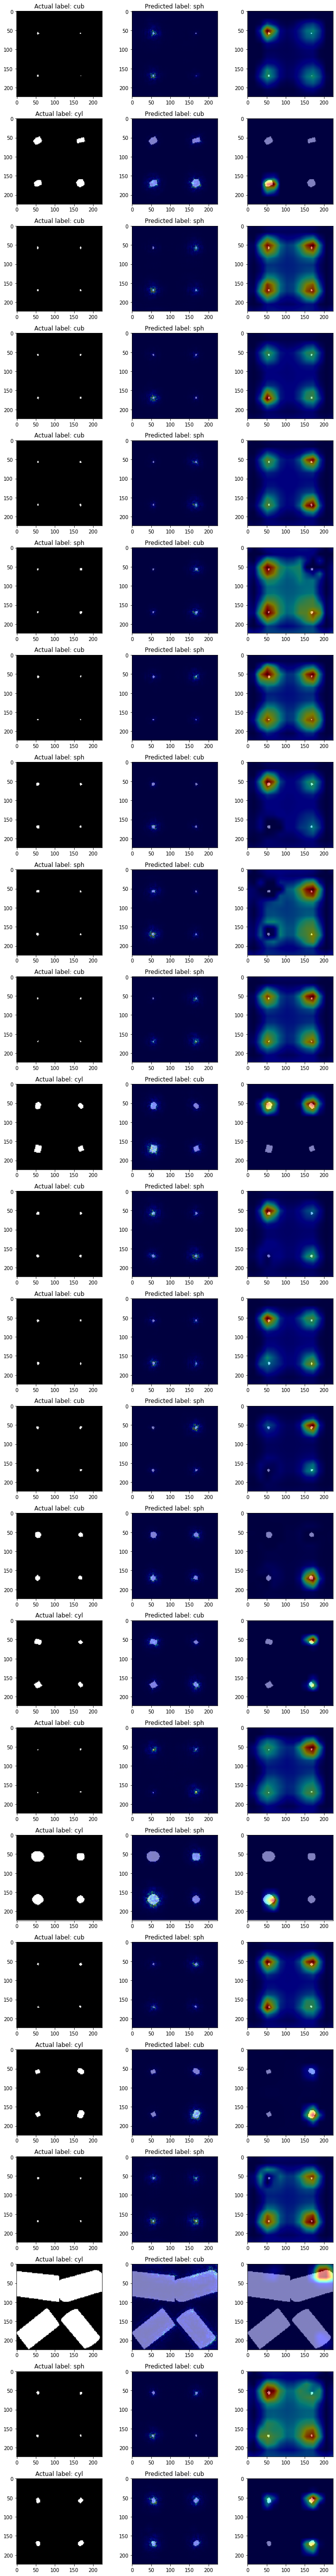

In [ ]:
# Create Saliency object.
saliency = Saliency(transfer_model,
                    model_modifier=ReplaceToLinear(),
                    clone=True)
# Create GradCAM object
gradcam = Gradcam(transfer_model,
                  model_modifier=ReplaceToLinear(),
                  clone=True)

fig, ax = plt.subplots(24,3,figsize=(10,72))

for i in range(24):
  ax[i][0].imshow(x_test[failed_predictions[i]])
  ax[i][0].set_title(f'Actual label: {label_to_prediction_test[y_true[failed_predictions[i]]]}')
  # Generate saliency map
  score = CategoricalScore(y_true[failed_predictions[i]])
  saliency_map = saliency(score,tf.convert_to_tensor(x_test[failed_predictions[i]], dtype=tf.float32))
  # Render
  ax[i][1].imshow(x_test[failed_predictions[i]])
  heatmap = np.uint8(cm.jet(saliency_map[0])[..., :3] * 255)
  ax[i][1].imshow(heatmap, cmap='jet', alpha=0.5) # overlay
  
  ax[i][1].set_title(f'Predicted label: {label_to_prediction[y_pred_vgg[failed_predictions[i]]]}')

  # Generate cam with GradCAM
  score = CategoricalScore(y_true[failed_predictions[i]])
  cam = gradcam(score,tf.convert_to_tensor(x_test[failed_predictions[i]], dtype=tf.float32))

  ax[i][2].imshow(x_test[failed_predictions[i]])
  heatmap = np.uint8(cm.jet(cam[0])[..., :3] * 255)
  ax[i][2].imshow(heatmap, cmap='jet', alpha=0.5) # overlay
  
plt.tight_layout()
plt.show()

### Saving the dataframes and predictions from best model (vgg16) to use in the regression part

In [ ]:
df_train.to_csv('df_train.csv',index = False)
df_val.to_csv('df_val.csv',index = False)

In [ ]:
df_test['predicted_shape'] = [label_to_prediction[i] for i in y_pred_vgg]
df_test.to_csv('df_test.csv',index=False)